# **IMPORT LIBS**

## Import

Import standard libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from scipy import sparse
from openrec.tf1.legacy import ImplicitModelTrainer
from openrec.tf1.legacy.utils.evaluators import ImplicitEvalManager
from openrec.tf1.legacy.utils import ImplicitDataset
from openrec.tf1.legacy.recommenders import CML
from openrec.tf1.legacy.utils.evaluators import AUC
from openrec.tf1.legacy.utils.samplers import PairwiseSampler
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import os
import sys

Import our functions.

In [2]:
# Adjusts path to include the utilities.py file
sys.path.append('../')
# Imports it
from helper import *

Set training flag.

In [3]:
# Flag to retrain the model (in this notebook should always be False)
REPEAT_TRAINING = False

# **INITIALIZATION**

## Init

Initialize notebook parameters.

In [4]:
# Set the seed for reproducibility
seed = 2384795
np.random.seed(seed=seed)

Initialize paths.

In [5]:
# Preparing folder for output data
output_name = f"./generated_data/"
if os.path.exists(output_name) == False:
    os.makedirs(output_name)

## Define auxiliary functions

Define a function which we will use to get the number of unique users or items ids.

In [6]:
# Counts the number of rows in tp per value of "id" and returns all the couples (id, count)
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

Define a function which we will use to extract the biased testset.

In [7]:
# Data is the training set
def split_train_test_proportion(data):

    # Create a test df
    df_test = pd.DataFrame(columns=data.columns)

    # Precompute, for each user, the list of songs with a relevant rating
    user_positive_ratings = data[data["rating"] == 1].groupby("user_id")["item_id"].apply(set)
    
    # Get the minimum and maximum item id
    min_item, max_item = data['item_id'].min(), data['item_id'].max()

    # Initialize the range of indexes for the items
    items_ids = np.arange(min_item, max_item + 1)

    # Set the number of songs for each user (proportionally to what we did with Yahoo dataset)
    SONGS_FOR_BIASED_TEST = 90

    # Get the set of user ids
    users = set(data["user_id"].unique())

    # Extract the biased test set according to the reference paper
    for user_id in users:

        # Get SONGS_FOR_BIASED_TEST items
        np.random.shuffle(items_ids)
        test_items = set(items_ids[-SONGS_FOR_BIASED_TEST:])

        # Get which ones are positive
        pos_ids = user_positive_ratings.get(user_id, set()) & test_items

        # Get which ones are negative but still in test_items
        neg_ids = test_items - pos_ids

        # Set the positive ones to 0 in the training set (Extracting)
        data.loc[(data['item_id'].isin(pos_ids)) & (data['user_id'] == user_id), 'rating'] = 0

        # Now add them in the test set
        # [user_id, pos_ids, 1]
        for item_id in pos_ids:
            df_test = df_test.append({'user_id': user_id, 'item_id': item_id, 'rating': 1}, ignore_index=True)
        # [user_id, neg_ids, 0]
        for item_id in neg_ids:
            df_test = df_test.append({'user_id': user_id, 'item_id': item_id, 'rating': 0}, ignore_index=True)

    # Convert back to the correct data types
    data['user_id'] = data['user_id'].astype(int)
    data['item_id'] = data['item_id'].astype(int)
    data['rating'] = data['rating'].astype(int)
    # For both training set and biased test set
    df_test['user_id'] = df_test['user_id'].astype(int)
    df_test['item_id'] = df_test['item_id'].astype(int)
    df_test['rating'] = df_test['rating'].astype(int)
    
    # Return
    return data, df_test


# **IMPORT DATA**

In this section we will just be using the code provided by the authors of the paper.

## Training and unbiased testsets

Load the data of the training and the unbiased testsets.

In [8]:
# Directory where the original data is stored
DATA_DIR = './original_files/'

# Load the data
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train.ascii'), sep=" ", header=None, engine="python")
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.ascii'), sep=" ", header=None, engine="python")

# Make them DataFrames
tr_vd_data = pd.DataFrame({"userId": sparse.coo_matrix(raw_data).row, "songId": sparse.coo_matrix(raw_data).col, "rating": sparse.coo_matrix(raw_data).data})
test_data = pd.DataFrame({"userId": sparse.coo_matrix(test_data).row, "songId": sparse.coo_matrix(test_data).col, "rating": sparse.coo_matrix(test_data).data})

Make them implicit.

In [9]:
# Suggested on the original yahoo's paper
POSITIVE_THRESHOLD = 4

# Add column to the DataFrame
tr_vd_data['ImplicitRating'] = np.where(tr_vd_data['rating'] >= POSITIVE_THRESHOLD, 1, 0)
test_data['ImplicitRating'] = np.where(test_data['rating'] >= POSITIVE_THRESHOLD, 1, 0)

# Rename columns into 'rating'
tr_vd_data = tr_vd_data.drop(['rating'],axis=1).rename({"ImplicitRating":"rating"}, axis='columns')
test_data = test_data.drop(['rating'],axis=1).rename({"ImplicitRating":"rating"}, axis='columns')

Print some stats.

In [10]:
# Count items per users
unique_uid = get_count(tr_vd_data, 'userId').index
# And users per item
unique_sid = get_count(tr_vd_data, 'songId').index

# Get the number of users and items
n_users = len(unique_uid)
n_items = len(unique_sid)

# Visualize
n_users, n_items

(290, 300)

Remove rows in the test set which are not in the training set.

In [11]:
# For the unbiased test set, only keep the users and items which exist in the training set
test_data = test_data.loc[test_data['userId'].isin(unique_uid)]
test_data = test_data.loc[test_data['songId'].isin(unique_sid)]

Turn userId and songId to 0-based index.

In [12]:
# Get dictionaries which associate the user and item ids to a number
user2id = {uid: i for i, uid in enumerate(unique_uid)}
song2id = {sid: i for i, sid in enumerate(unique_sid)}

# Define piece of code which changes the ids in the DataFrame
def numerize(tp):
    tp['user_id'] = tp['userId'].apply(lambda x: user2id[x])
    tp['item_id'] = tp['songId'].apply(lambda x: song2id[x])
    return tp[['user_id', 'item_id', 'rating']]

# Apply the function
tr_vd_data = numerize(tr_vd_data)
test_data = numerize(test_data)

And save the unbiased testset on the output files.

In [13]:
# Store
test_data.to_csv(os.path.join(output_name, 'test_full.csv'), index=False)

## Biased testset

Extract the biased testset.

In [14]:
# Get the train and biased test data
train_data, obs_test_data = split_train_test_proportion(tr_vd_data)

And save it.

In [15]:
# Biased test set
obs_test_data.to_csv(os.path.join(output_name, 'obs_test_full.csv'), index=False)

# Original training set
tr_vd_data.to_csv(os.path.join(output_name, 'train_full.csv'), index=False)
# Training set after the extraction of the biased test set
train_data.to_csv(os.path.join(output_name, 'train.csv'), index=False)

# **BUILD PICKLES FILES**

# Biased testset

Split in positive and negative ratings.

In [16]:
# Init empty
pos_test_set = []
neg_test_set = []

# Create masks for positive and negative ratings
pos_mask = obs_test_data['rating'] == 1
neg_mask = obs_test_data['rating'] != 1

# Extract the user_id and item_id pairs for positive and negative ratings
pos_test_set = obs_test_data.loc[pos_mask, ['user_id', 'item_id']].values.tolist()
neg_test_set = obs_test_data.loc[neg_mask, ['user_id', 'item_id']].values.tolist()

# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

And save the files.

In [17]:
# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "biased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "biased-test_arr_neg.npy", structured_data_neg_test_set)

# Unbiased testset

Split in positive and negative ratings.

In [18]:
# Init empty
pos_test_set = []
neg_test_set = []

# Create masks for positive and negative ratings
pos_mask = test_data['rating'] == 1
neg_mask = test_data['rating'] != 1

# Extract the user_id and item_id pairs for positive and negative ratings
pos_test_set = test_data.loc[pos_mask, ['user_id', 'item_id']].values.tolist()
neg_test_set = test_data.loc[neg_mask, ['user_id', 'item_id']].values.tolist()

# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

And save the files.

In [19]:
# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "unbiased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "unbiased-test_arr_neg.npy", structured_data_neg_test_set)

# Trainset

In [20]:
# Only take the couples (user, item) with relevant rating
positive_trainset = train_data[train_data['rating'] != 0]
positive_trainset = positive_trainset.drop(columns=['rating'])

# Convert the DataFrame to a structured array
positive_trainset = positive_trainset.to_records(index=False) 

# Save
np.save(output_name + "training_arr.npy", positive_trainset)

# **LOAD DATA**

In this section we will just be using the code provided by the authors of the paper.

## Read from output files

We will load the data from the output files (we could avoid doing so, but let's just use their code).

In [21]:
# Init dictionary for data
raw_data = dict()
raw_data['max_user'] = 290
raw_data['max_item'] = 300

# Load train and test data from files
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['test_data_pos_biased'] = np.load(output_name + "biased-test_arr_pos.npy")
raw_data['test_data_neg_biased'] = np.load(output_name + "biased-test_arr_neg.npy")
raw_data['test_data_pos_unbiased'] = np.load(output_name + "unbiased-test_arr_pos.npy")
raw_data['test_data_neg_unbiased'] = np.load(output_name + "unbiased-test_arr_neg.npy")

# Form the datasets
train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')
test_dataset_pos_biased = ImplicitDataset(raw_data['test_data_pos_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_biased = ImplicitDataset(raw_data['test_data_neg_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_pos_unbiased = ImplicitDataset(raw_data['test_data_pos_unbiased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_unbiased = ImplicitDataset(raw_data['test_data_neg_unbiased'], raw_data['max_user'], raw_data['max_item'])

# **TRAIN THE MODEL**

In this section we will just be using the code provided by the authors.

## Init

Prepare names and paths.

In [22]:
# Initialize metadata and paths
MODEL_CLASS = CML
MODEL_PREFIX = "cml"
DATASET_NAME = "coat"
OUTPUT_FOLDER = output_name
OUTPUT_PATH = OUTPUT_FOLDER + MODEL_PREFIX + "-" + DATASET_NAME + "/"
OUTPUT_PREFIX = str(OUTPUT_PATH) + str(MODEL_PREFIX) + "-" + str(DATASET_NAME)
if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

## Training

This is to ensure that TensorFlow starts with a clean state and that the results are reproducible by setting a random seed.

In [23]:
# Prevent tensorflow from using cached embeddings and set seed
import tensorflow as tf
tf.compat.v1.reset_default_graph()
tf.set_random_seed(seed)

Train and save the model on the output file.

In [24]:
# Set parameters to define and train the model
batch_size = 8000
test_batch_size = 1000
display_itr = 1000
num_itr = 10001

# If training is meant to be done again
if REPEAT_TRAINING:

    # Define the model
    model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
    sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
    model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
    auc_evaluator = AUC()

    # Train the model
    model_trainer.train(num_itr=num_itr, display_itr=display_itr)

    # And save it in the output folder
    model.save(OUTPUT_PATH,None)

    # Delete the model from the memory (we will load it later)
    del model

# **LOAD MODEL**

In this section we will just be using the code provided by the authors of the paper.

Load model.

In [25]:
# Prevent tensorflow from using cached embeddings
tf.compat.v1.reset_default_graph()

# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Load the model
model.load(OUTPUT_PATH)

# Set further parameters
model_trainer._eval_manager = ImplicitEvalManager(evaluators=[auc_evaluator])
model_trainer._num_negatives = 200
model_trainer._exclude_positives([train_dataset, test_dataset_pos_biased, test_dataset_neg_biased])
model_trainer._sample_negatives(seed=10)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2024-08-25 16:35:41.572106: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-08-25 16:35:41.574592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4192055000 Hz
2024-08-25 16:35:41.575083: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a878976b80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-25 16:35:41.575099: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


INFO:tensorflow:Restoring parameters from ./generated_data/cml-coat/
[Subsampling negative items]


# **EVALUATION**

In this section we will just be using the code provided by the authors of the paper.

## Biased Evaluation

Compute recommendations with biased testset.

In [26]:
# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-biased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_pos_biased)

# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-biased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_neg_biased)

  0%|          | 0/231 [00:00<?, ?it/s]/home/japo/miniconda3/envs/RecSys-Evaluation/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/japo/miniconda3/envs/RecSys-Evaluation/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 290/290 [00:01<00:00, 284.67it/s]


{'AUC': [0.5048255813953489,
  0.5586516853932584,
  0.4794886363636363,
  0.5031818181818182,
  0.5090449438202247,
  0.420344827586207,
  0.46852272727272726,
  0.49073033707865166,
  0.4794252873563216,
  0.5647701149425286,
  0.5099444444444445,
  0.5607558139534883,
  0.5206666666666666,
  0.5400561797752809,
  0.5360555555555556,
  0.530056179775281,
  0.5154444444444445,
  0.5315730337078652,
  0.48829545454545453,
  0.518314606741573,
  0.4800581395348836,
  0.5804069767441861,
  0.4154117647058822,
  0.4808988764044945,
  0.5013095238095239,
  0.47331460674157305,
  0.508735632183908,
  0.49859550561797755,
  0.505,
  0.503876404494382,
  0.48282352941176476,
  0.5546067415730337,
  0.4758522727272727,
  0.5150555555555556,
  0.4951123595505619,
  0.4927272727272728,
  0.515625,
  0.5448333333333333,
  0.49189655172413793,
  0.48682352941176465,
  0.4775842696629213,
  0.5447727272727273,
  0.5505813953488372,
  0.4810112359550562,
  0.5312359550561798,
  0.5608426966292134,
 

## Unbiased Evaluation

Compute recommendations with biased testset.

In [27]:
# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-unbiased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_pos_unbiased)

# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-unbiased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_neg_unbiased)

100%|██████████| 290/290 [00:00<00:00, 1204.72it/s]


{'AUC': [0.5135000000000001,
  0.5392857142857143,
  0.4946153846153845,
  0.5307692307692308,
  0.5334615384615385,
  0.5582142857142857,
  0.5213333333333334,
  0.58875,
  0.4928125,
  0.4919230769230769,
  0.38884615384615384,
  0.4535,
  0.5203571428571429,
  0.5775,
  0.4513333333333333,
  0.6992857142857142,
  0.5428124999999999,
  0.4446428571428572,
  0.5196428571428571,
  0.5793333333333333,
  0.4353333333333333,
  0.6041666666666666,
  0.31437499999999996,
  0.5215625,
  0.5090909090909091,
  0.4932142857142857,
  0.5800000000000001,
  0.4753333333333334,
  0.5278571428571429,
  0.4821428571428572,
  0.39454545454545453,
  0.4842857142857143,
  0.44766666666666666,
  0.45545454545454545,
  0.5428571428571429,
  0.29500000000000004,
  0.45166666666666666,
  0.41343749999999996,
  0.3983333333333334,
  0.34299999999999997,
  0.38687499999999997,
  0.47923076923076924,
  0.6506666666666666,
  0.6233333333333334,
  0.5359999999999999,
  0.5356666666666666,
  0.5239285714285714,
 

# **COMPUTE RESULTS**

## Preprocessing

Here we first preprocess the propensities from the training set data.

In [28]:
# Preprocess the propensities
propensities = calculate_propensities(raw_data['max_user'], raw_data['max_item'], output_name+"training_arr.npy", normalize=True)

## Compute rivals metrics

Now set the gamma values to be considered.

In [29]:
# Choose values for gamma
GAMMAS = [1.5, 2, 2.5, 3]

Compute AOA and IPS metrics for both biased and unbiased datasets.

In [30]:
# Init biased and unbiased results dictionaries
biased_results = dict()
unbiased_results = dict()

# Compute AOA results
biased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", K=30)
unbiased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", K=1)

# Compute IPS results
for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    biased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30)
    unbiased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1)

## Compute Stratified

Get array of possible values for the number of subsets in the partition.

In [31]:
# Get number of items
num_items = raw_data['max_item'] - 1

# Set the number of possible values to be considered
n_p = 299

# Get array with the first num_items natural numbers 
nums = np.arange(1, num_items+1)

# Choose n_p random values
partitions = np.random.choice(nums, n_p, replace=False)

Compute the partition p which minimizes the sum of Bias and Conc.

In [32]:
# Value of gamma to use for minimization
opt_gamma = 1.5

# Keys prefix in the dictionaries + gamma value
key = "STRATIFIED_" + str(opt_gamma).replace(".","")

# Init dictionaries to store results for biased and unbiased testset
unbiased_results[key] = {}
biased_results[key] = {}

# Random init for best partition
best_partition = np.random.choice(nums, 1)[0]
# Init infinity as min score
best_score = float('inf')

# To plot the results init histories
history_objective = np.full(num_items, np.inf)
history_mae_auc = np.full(num_items, np.inf)
history_mae_recall = np.full(num_items, np.inf)
history_bound = np.full(num_items, np.inf)

# For each value in the partitions array (n_p random values from 1 to num_items)
for p in tqdm(partitions):

    # Fetch stratified results
    temp_unbiased = stratified(OUTPUT_PREFIX + "-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX + "-test-neg-unbiased_evaluate_partial.pickle", output_name + "training_arr.npy", propensities[opt_gamma], K=1, partition=p)
    temp_biased = stratified(OUTPUT_PREFIX + "-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX + "-test-neg-biased_evaluate_partial.pickle", output_name + "training_arr.npy", propensities[opt_gamma], K=30, partition=p)
      
    # Computing bound score
    bound_score = temp_unbiased['bias'] + temp_unbiased['concentration'] + temp_biased['bias'] + temp_biased['concentration']
    # Compute maes to plot the history
    mae_score_auc = abs(temp_unbiased['auc'] - temp_biased['auc'])   
    mae_score_recall = abs(temp_unbiased['recall'] - temp_biased['recall'])
    
    # Set objective (to switch between the bound and the MAE to check whether the bound is a good metric)
    objective = bound_score 
    
    # Storing historical values
    history_mae_auc[p-1] = mae_score_auc  # Store the mae using auc
    history_mae_recall[p-1] = mae_score_recall  # Store the mae using recall
    history_bound[p-1] = bound_score  # Store the bound score

    # Update the best_partition and best_score if the current partition's bound is lower
    if objective < best_score:
        best_score = objective
        best_partition = p

# Print the best partition and the combined score
print(f"Best partition: {best_partition} with combined score: {best_score}")

  0%|          | 0/299 [00:00<?, ?it/s]

Best partition: 6 with combined score: 466475.4570742578


Plot MAE with AUC over each considered partition.

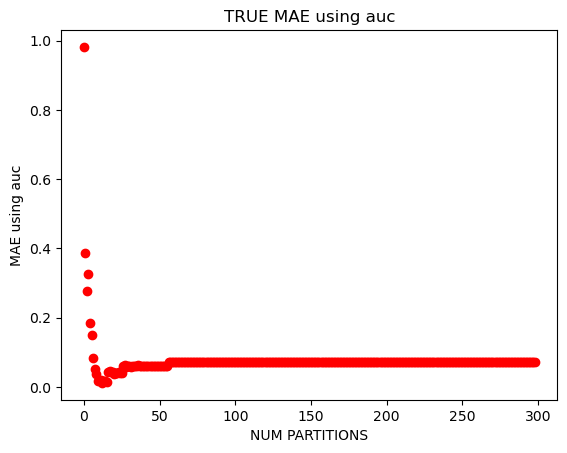

In [33]:
# Get p values (only the ones which were considered)
x = np.where(history_mae_auc != np.inf)
# Get MAE values with AUC
y = history_mae_auc[history_mae_auc != np.inf]
 
# Plot
plt.title("TRUE MAE using auc") 
plt.xlabel("NUM PARTITIONS") 
plt.ylabel("MAE using auc") 
plt.scatter(x, y, color ="red") 
plt.show()

Plot MAE with Recall over each considered partition.

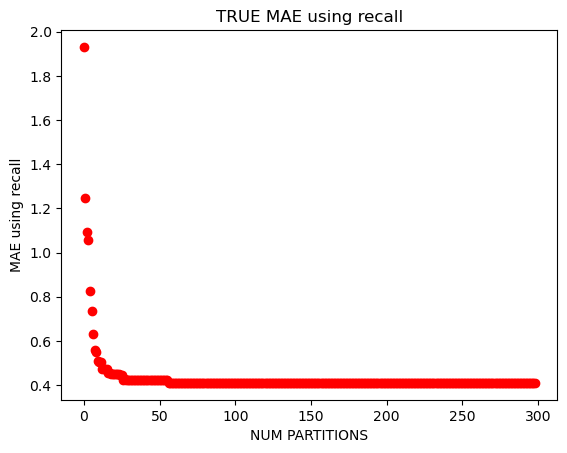

In [34]:
# Get p values (only the ones which were considered)
x = np.where(history_mae_recall != np.inf)
# Get MAE values with recall
y = history_mae_recall[history_mae_recall != np.inf]
 
# Plot
plt.title("TRUE MAE using recall") 
plt.xlabel("NUM PARTITIONS") 
plt.ylabel("MAE using recall") 
plt.scatter(x, y, color ="red") 
plt.show()

Plot the bound over each considered partition.

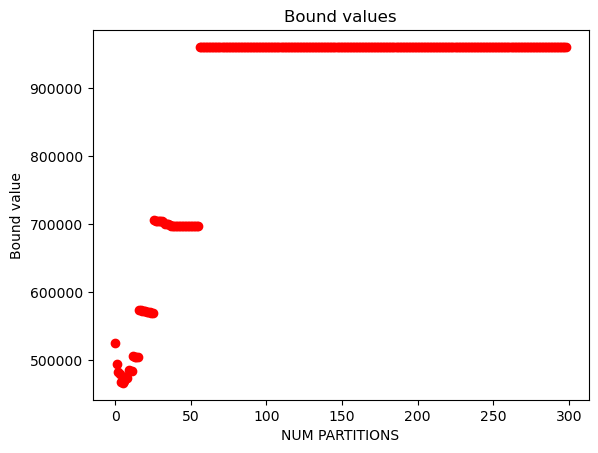

In [35]:
# Get p values (only the ones which were considered)
x = np.where(history_bound != np.inf)
# Get the bound values
y = history_bound[history_bound != np.inf]
 
# Plot
plt.title("Bound values") 
plt.xlabel("NUM PARTITIONS") 
plt.ylabel("Bound value") 
plt.scatter(x, y, color ="red") 
plt.show()

Now finally compute the evaluation with the Stratified estimator.

In [36]:
# Compute Stratified results
for gamma in GAMMAS:
    key = "STRATIFIED_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)

This version builds a partition evenly distributing the items instead of the propensities.

In [37]:
# Compute Stratified results with the second version
for gamma in GAMMAS:
    key = "STRATIFIED_v2_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)


Prepare table for results.

In [38]:
# Set number of columns as number of estimators which were used
columns = len(biased_results.keys())

# Determine the maximum number (number of used metrics)
rows = max(max(len(biased_results[key].keys()) for key in biased_results.keys()), max(len(unbiased_results[key].keys()) for key in unbiased_results.keys()))

# Init matrix to store results
results_array = np.zeros((rows,columns))

# Get the names of the rows
list_biased_res = list(biased_results.keys())

Fill the table with the MAE results and get the DataFrame object.

In [39]:
# For each evaluator
for i in range(len(list_biased_res)):
    key = list_biased_res[i]

    # For each metric
    for j in range(len(list(biased_results[key].keys()))):
        key_2 = list(biased_results[key].keys())[j]

        # Compute MAE between biased and unbiased results
        results_array[j][i] = abs(biased_results[key][key_2] - unbiased_results[key][key_2])

# Make it a DataFrame
mae_df = pd.DataFrame(columns=list(biased_results.keys()), data=results_array)
metric_values = list(biased_results[list(biased_results.keys())[0]].keys())
mae_df.insert(0, "metric", metric_values)

# **RESULTS**

## Visualize

Remembering that...

In [40]:
# Print the results
print("Minimization was done for gamma = ", opt_gamma, ". The best number of partitions: ", best_partition)

Minimization was done for gamma =  1.5 . The best number of partitions:  6


Visualize.

In [41]:
# Visualize
mae_df.head()

,metric,AOA,UB_15,UB_2,UB_25,UB_3,STRATIFIED_15,STRATIFIED_2,STRATIFIED_25,STRATIFIED_3,STRATIFIED_v2_15,STRATIFIED_v2_2,STRATIFIED_v2_25,STRATIFIED_v2_3
0,auc,0.045192,0.072801,0.076456,0.079413,0.081773,0.150232,0.198115,0.825502,1.129837,0.139229,0.167865,0.202610,2.454464e-01
1,recall,0.416553,0.409646,0.408435,0.407269,0.406158,0.737324,1.140838,2.097933,3.353929,0.497771,0.528675,0.567832,6.173550e-01
2,bias,0.000000,0.000000,0.000000,0.000000,0.000000,15531.073581,31075.008683,59969.769349,106585.381473,729.451991,919.754088,1132.589869,1.351477e+03
3,concentration,0.000000,0.000000,0.000000,0.000000,0.000000,26587.720125,63865.156344,146944.524485,342137.920880,63270.665015,164799.389359,421609.212405,1.064287e+06
